In this tutorial we will use redner to optimize the translational and rotational parameters of an object.

As in the previous tutorial, we will import pyredner_tensorflow and tensorflow, and download the teapot object.

In [1]:
import pyredner_tensorflow as pyredner
import tensorflow as tf
# Tensorflow by default allocates all GPU memory, leaving very little for rendering.
# We set the environment variable TF_FORCE_GPU_ALLOW_GROWTH to true to enforce on demand
# memory allocation to reduce page faults.
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Workaround for an OpenMP issue on Mac OS.
import tensorflow as tf
tf.compat.v1.enable_eager_execution() # redner only supports eager mode

In [2]:
import urllib
import zipfile
# wget
filedata = urllib.request.urlretrieve('https://casual-effects.com/g3d/data10/common/model/teapot/teapot.zip', 'teapot.zip')
# unzip
zip_ref = zipfile.ZipFile('teapot.zip', 'r')
zip_ref.extractall('teapot/')

In [3]:
objects = pyredner.load_obj('teapot/teapot.obj', return_objects=True)
camera = pyredner.automatic_camera_placement(objects, resolution=(512, 512))

Next, we define a `model` function that takes the objects, camera, and pose parameters, and output an image.

In [4]:
# Obtain the teapot vertices we want to apply the transformation on.
vertices = []
for obj in objects:
    vertices.append(tf.identity(obj.vertices))
# Compute the center of the teapot
center = tf.reduce_mean(tf.concat(vertices, axis=0), axis=0)
def model(translation, euler_angles):
    # Get the rotation matrix from Euler angles
    rotation_matrix = pyredner.gen_rotate_matrix(euler_angles)
    # Shift the vertices to the center, apply rotation matrix,
    # shift back to the original space, then apply the translation.
    for obj, v in zip(objects, vertices):
        obj.vertices = (v - center) @ tf.transpose(rotation_matrix) + center + translation
    # Assemble the 3D scene.
    scene = pyredner.Scene(camera = camera, objects = objects)
    # Render the scene.
    img = pyredner.render_albedo(scene)
    return img

To do pose estimation, we need a target image. In this toy example we use the default pose to render a target image.

In [5]:
target_translation = tf.constant([0.0, 0.0, 0.0])
target_euler_angles = tf.constant([0.0, 0.0, 0.0])

In [6]:
target = model(target_translation, target_euler_angles)

Scene construction, time: 0.06143 s
Forward pass, time: 0.62768 s


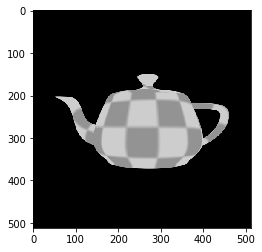

In [7]:
# Visualize target
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(target)

Now we generate the initial guess for the pose estimation.

Scene construction, time: 0.06488 s
Forward pass, time: 0.65967 s


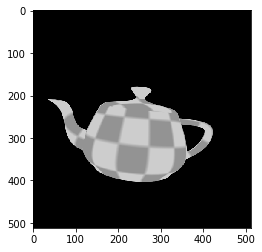

In [8]:
# Set requires_grad=True since we want to optimize them later
translation = tf.Variable([10.0, -10.0, 10.0])
euler_angles = tf.Variable([0.1, -0.1, 0.1])
init = model(translation, euler_angles)
# Visualize the initial guess
imshow(init)

Next, we optimize the pose using Adam. We build two optimizers to have different learning rates for translation and rotation, since they have different dynamic ranges.

In [9]:
t_optimizer = tf.compat.v1.train.AdamOptimizer(0.5)
r_optimizer = tf.compat.v1.train.AdamOptimizer(0.01)

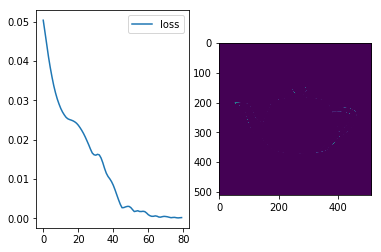

In [10]:
# Setup plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
plt.figure()
imgs, losses = [], []
# Run 80 Adam iterations
num_iters = 80
for t in range(num_iters):
    with tf.GradientTape() as tape:
        img = model(translation, euler_angles)
        # Compute the loss function. Here it is L2.
        loss = tf.reduce_mean(tf.square(img - target))

    grads = tape.gradient(loss, [translation, euler_angles])
    t_optimizer.apply_gradients(zip([grads[0]], [translation]))
    r_optimizer.apply_gradients(zip([grads[1]], [euler_angles]))
    # Plot the loss
    f, (ax_loss, ax_img) = plt.subplots(1, 2)
    losses.append(loss)
    imgs.append(img) # Record the image
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_img.imshow(tf.reduce_sum(tf.square(img -target), axis=2))
    plt.show()


We can visualize the intermediate images using matplotlib:

In [11]:
%%capture
from matplotlib import animation
from IPython.display import HTML
fig = plt.figure()
im = plt.imshow(imgs[0], animated=True)
def update_fig(i):
    im.set_array(imgs[i])
    return im,
anim = animation.FuncAnimation(fig, update_fig, frames=len(imgs), interval=50, blit=True)

In [12]:
from IPython.display import HTML
HTML(anim.to_jshtml())